In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cm2inch(value):
    return value/2.54

In [3]:
plotsize_subplots = (cm2inch(19),cm2inch(3.5))
#plotsize_subplots = (16,3)

#plotsize_mem_conn_subplots = (cm2inch(17),cm2inch(7))

fontsize_axis = 7
fontsize_labels = 7
fontsize_legends = 4

#print(plt.rcParams.keys())

plt.rcParams.update({'figure.figsize': plotsize_subplots,
                     'axes.titlesize': fontsize_labels,
                     'axes.labelsize': fontsize_labels,
                     'ytick.labelsize': 'small'})

# Functions

In [46]:
def calculate_T_conn_and_memory(df):
    """Calculate T_conn and memory_per_rank"""
    df['T_bld_xn'] = df['T_conns_min'] + df['T_ini_max']
    df['T_bld_nx'] = df['T_conns_max'] + df['T_ini_min']
    df['Conn. Total']   = df[['T_bld_xn', 'T_bld_nx']].min(axis=1)
    df['Conn. Creation (min)'] = df['T_conns_min']
    df['Conn. Exchange (min)'] = df['T_ini_min']

    
    if 'NUM_VPS' not in list(df):
        df['N_VP'] = df['NUMBER_OF_NODES']*df['TASKS_PER_NODE']*df['THREADS_PER_TASK']
    else:
        df['N_VP'] = df['NUM_VPS']
    if np.isnan(df['VSize_sum']).all():
        df['VSize_sum'] = df['VSize_ini_sum']
    if 'VSize_mem_sum' not in list(df) and 'VSize_nodes_sum' not in list(df): #MAM
        df['VSize_mem_sum'] = df['VSize_net_sum']
        df['VSize_nodes_sum'] = [0]*len(df)
    
    # Er denne konverteringen riktig?
    # Vi har MiB = 1024**2 B
    # Verdien vi får fra NEST er i KiB (http://www.nest-simulator.org/helpindex/sli/memory_thisjob.html)
    
    df['connections'] = ((df['VSize_mem_sum']-df['VSize_nodes_sum'])/df['NUM_VPS'])*1024/1024**3
    df['ini'] = ((df['VSize_ini_sum']-df['VSize_mem_sum'])/df['NUM_VPS'])*1024/1024**3
    df['other'] = (df['VSize_sum']/df['NUM_VPS'])*1024/1024**3 - df['connections'] - df['ini']
    df['Memory per Rank'] = (df['VSize_sum']/df['NUM_VPS'])*1024/1024**3
    
    if False:
        print(df['connections'])
        print(df['ini'])
        print(df['other'])
        print(df['connections'] + df['ini'] + df['other'])
        print(df['memory_per_rank'])

        print((df['connections'] + df['ini'] + df['other']) == df['memory_per_rank'])

    return df

In [7]:
def time_per_connection(df):
    df['Total Conn. Time per Conn.'] = df['Conn. Total']/df['N_conns_sum']
    df['Conn. Creation Time per Conn. (min)'] = df['Conn. Creation (min)']/df['N_conns_sum']
    df['Conn. Exchange Time per Conn. (min)'] = df['Conn. Exchange (min)']/df['N_conns_sum']
    return df

In [57]:
def plot_results(df, name, plot_T_sim=True, index=None, legend_loc='lower right', rot=45):
    ncols = 4
    values = ['Conn. Exchange (min)', 'Conn. Creation (min)', 'Conn. Total']
    
    if not index:
        index='N_VP'
    
    if plot_T_sim:
        values += ['T_sim']
        ncols += 1
    
    df_p = pd.pivot_table(df, index=[index], values=values)
    df_mem = pd.pivot_table(df, index=[index], values=['connections', 'ini', 'other'])
    
    # Make subplots
    fig, axes = plt.subplots(nrows=1, ncols=ncols)
    
    df_p.plot(kind='bar', capsize=4, subplots=True, legend=False, ax=axes[:ncols-1], fontsize=fontsize_axis,
              rot=rot, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
    df_mem.plot(kind='bar', capsize=4, stacked=True, legend=True, ax=axes[ncols-1],
                fontsize=fontsize_axis, rot=rot, color=['purple', 'pink', 'red'])
    
    plt.legend(labels=('Connections', 'Exchange', 'Other'), fontsize=6, loc=legend_loc)
    
    plt.subplots_adjust(wspace=0.4)
    
    # dashed line
    for i, val_name in enumerate(list(df_p)):
        axes[i].axhline(y=df[val_name][0], linestyle='--', color='grey')
        axes[i].set_xlabel(index)
    
    # y-axes labels
    axes[0].set_ylabel('Time [s]')
    
    # memory plot
    axes[ncols-1].axhline(y=df['Memory per Rank'][0], linestyle='--', color='grey')
    axes[ncols-1].set_ylabel('Memory [GiB]')
    axes[ncols-1].set_title('Memory per Rank')
    axes[ncols-1].set_xlabel(index)
    axes[ncols-1].ticklabel_format(style='sci', scilimits=(-3,2), axis='y', useMathText=False)
    axes[ncols-1].get_yaxis().get_offset_text().set_position((-0.2,0))
    
    fig.savefig(name, bbox_inches='tight')
    
    df_p['connections'] = df_mem['connections']
    df_p['ini'] = df_mem['ini']
    df_p['other'] = df_mem['other']
    return df_p

In [47]:
def plot_compare(df, name, values=None, index=None, legend_loc='lower right', rot=45):
    """Plot times for different cases"""
    
    if not values:
        values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per Rank']
    if not index:
        index='N_VP'
    df_p = pd.pivot_table(df, index=index, columns='Case', values=values)


    # Make subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(values))

    for indx, val_name in enumerate(values):
        df_p[val_name].plot(kind='bar', ax = axes[indx], title=val_name, fontsize=fontsize_axis, rot=rot)
        axes[indx].legend(fontsize=fontsize_legends, loc=legend_loc)

    plt.subplots_adjust(wspace=0.4)

    # y-axis labels
    axes[0].set_ylabel('Time [s]')
    if 'Memory per Rank' in values:
        # Assume memory is last entry in values
        axes[len(values) - 1].set_ylabel('Memory [GiB]')

    # x-axis labels
    for ax in axes:
        ax.set_xlabel(index)

    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

In [6]:
def save_table_latex(text, name):
    f = open(name, "w")
    f.write(text)
    f.close()

# FIG. 1

## HPC_benchmark

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,54.30,42.19,99.81,2.743245,0.019534,0.055616
72,53.72,42.97,102.35,2.743245,0.024010,0.053295
144,54.19,44.75,105.35,2.743245,0.109460,0.053315
288,53.67,48.82,109.34,2.743245,0.114370,0.053327
576,52.43,60.34,120.57,2.743245,0.240082,0.053680
1152,52.39,79.09,139.73,2.743083,0.576400,0.054545


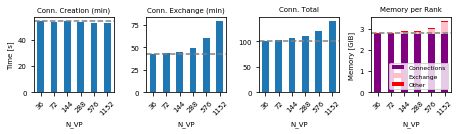

In [58]:
hpc_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20.csv')

hpc_t6_s20 = calculate_T_conn_and_memory(hpc_t6_s20)
hpc_t6_s20_p = plot_results(hpc_t6_s20, 'benchmark_figures/hpc_benchmark.pdf', plot_T_sim=False)

save_table_latex(hpc_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_table.txt')
hpc_t6_s20_p

## HPC delay 0.1 - 50.

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,T_sim,connections,ini,other
NUM_VPS,,,,,,,
36,53.56,45.38,103.50,134.70,1.930745,0.392907,0.051058
72,51.74,46.95,107.41,133.91,1.930745,0.392907,0.053295
144,52.82,46.63,105.05,147.27,1.930745,0.394128,0.053315
288,52.01,50.14,111.17,167.28,1.930745,0.477530,0.053327
576,52.04,66.64,128.82,221.18,1.951579,0.459646,0.053680
1152,52.05,85.56,147.11,353.64,1.993083,0.460135,0.054545


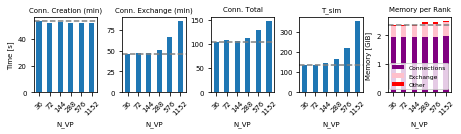

In [12]:
hpc_delay_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20_delays.csv')

hpc_delay_t6_s20 = calculate_T_conn_and_memory(hpc_delay_t6_s20)
hpc_delay_t6_s20_p = plot_results(hpc_delay_t6_s20, 'benchmark_figures/hpc_benchmark_diff_delays.pdf')

save_table_latex(hpc_delay_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_diff_delays_table.txt')
hpc_delay_t6_s20_p

## HPC static, delay 0.1-50.

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,T_sim,connections,ini,other
NUM_VPS,,,,,,,
36,53.56,45.38,103.50,134.70,1.930745,0.392907,0.051058
72,51.74,46.95,107.41,133.91,1.930745,0.392907,0.053295
144,52.82,46.63,105.05,147.27,1.930745,0.394128,0.053315
288,52.01,50.14,111.17,167.28,1.930745,0.477530,0.053327
576,52.04,66.64,128.82,221.18,1.951579,0.459646,0.053680
1152,52.05,85.56,147.11,353.64,1.993083,0.460135,0.054545


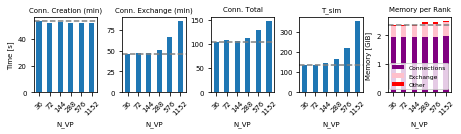

In [63]:
hpc_static_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20_static_delays.csv')

hpc_static_t6_s20 = calculate_T_conn_and_memory(hpc_static_t6_s20)
hpc_static_t6_s20_p = plot_results(hpc_static_t6_s20, 'benchmark_figures/hpc_benchmark_static_diff_delays.pdf')

save_table_latex(hpc_static_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_static_diff_delays_table.txt')
hpc_static_t6_s20_p

## HPC Split into many Connect calls

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
NUM_VPS,,,,,,
36,93.72,43.75,140.69,2.743245,0.018721,0.058383
72,95.04,44.08,141.95,2.743245,0.038740,0.127677
144,97.74,45.64,149.15,2.743245,0.103275,0.231606
288,102.46,48.82,160.06,2.743245,0.104300,0.458369
576,112.52,57.72,178.35,2.743245,0.181957,0.399136
1152,133.32,77.62,219.40,2.743083,0.553613,0.257282


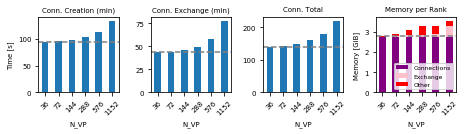

In [25]:
hpc_split_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20_split.csv')

hpc_split_t6_s20 = calculate_T_conn_and_memory(hpc_split_t6_s20)
hpc_split_t6_s20_p = plot_results(hpc_split_t6_s20, 'benchmark_figures/hpc_benchmark_split.pdf', plot_T_sim=False)

save_table_latex(hpc_split_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_split_table.txt')
hpc_split_t6_s20_p

## HPC split into many Connect calls, increasing number of NBLOCKS

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
NUM_VPS,,,,,,
36,93.72,43.51,141.45,2.743245,0.016279,0.057569
72,231.57,43.54,289.88,2.743245,0.040368,0.125398
144,753.47,42.66,847.58,2.826579,0.019128,0.214502
288,2744.99,44.27,3124.88,2.933350,0.116690,0.336835
576,NaN,NaN,NaN,NaN,NaN,NaN
1152,NaN,NaN,NaN,NaN,NaN,NaN


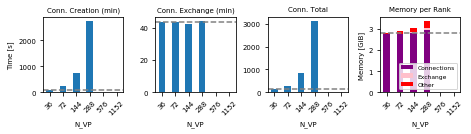

In [26]:
hpc_split_increase_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s20_split_increase.csv')

hpc_split_increase_t6_s20 = calculate_T_conn_and_memory(hpc_split_increase_t6_s20)
hpc_split_increase_t6_s20_p = plot_results(hpc_split_increase_t6_s20,
                                           'benchmark_figures/hpc_benchmark_split_increase.pdf', plot_T_sim=False)

save_table_latex(hpc_split_increase_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_split_increase_table.txt')
hpc_split_increase_t6_s20_p

## HPC comparing different cases from above

Conn. Creation (min)                      Conn. Exchange (min)  \
Case                 Default Random delay   Split              Default   
NUM_VPS                                                                  
36                     54.30        53.56   93.72                42.19   
72                     53.72        51.74   95.04                42.97   
144                    54.19        52.82   97.74                44.75   
288                    53.67        52.01  102.46                48.82   
576                    52.43        52.04  112.52                60.34   
1152                   52.39        52.05  133.32                79.09   

                            Conn. Total                      Memory per Rank  \
Case    Random delay  Split     Default Random delay   Split         Default   
NUM_VPS                                                                        
36             45.38  43.75       99.81       103.50  140.69        2.818396   
72             46.95  44.08      102.35       107.41  141.95        2.820551   
144            46.63  45.64      105.35       105.05  149.15        2.906020   
288            50.14  48.82      109.34       111.17  160.06        2.910942   
576            66.64  57.72      120.57       128.82  178.35        3.037008   
1152           85.56  77.62      139.73       147.11  219.40        3.374027   

                                
Case    Random delay     Split  
NUM_VPS                         
36          2.374711  2.820349  
72          2.376948  2.909662  
144         2.378188  3.078126  
288         2.461602  3.305914  
576         2.464905  3.324338  
1152        2.507762  3.553978

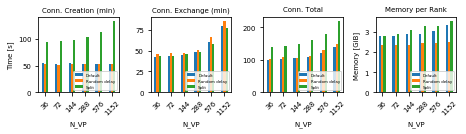

In [101]:
hpc_t6_s20['Case'] = ['Default'] * len(hpc_t6_s20)
hpc_delay_t6_s20['Case'] = ['Random delay'] * len(hpc_delay_t6_s20)
hpc_split_t6_s20['Case'] = ['Split'] * len(hpc_split_t6_s20)

hpc_cases = pd.concat([hpc_t6_s20, hpc_delay_t6_s20, hpc_split_t6_s20])

hpc_cases_p = plot_compare(hpc_cases, 'benchmark_figures/hpc_cases.pdf')
save_table_latex(hpc_cases_p.to_latex(), 'latex_tables/hpc_cases_table.txt')

hpc_cases_p

### HPC many connections per neuron
For comparison with population model

Important:
- N_nrns ~ 500 000 * NUMBER_OF_NODES
- N_conns_sum ~ 2 500 000 000 * NUMBER_OF_NODES

0     2498000500
1     4996000000
2     9991999000
3    19983997000
4    39967993000
5    79935985000
Name: N_conns_sum, dtype: int64
0      499500
1      999000
2     1998000
3     3996000
4     7992000
5    15984000
Name: N_nrns, dtype: int64


,Conn. Creation (min),Conn. Exchange (min),Conn. Total,T_sim,connections,ini,other
NUM_VPS,,,,,,,
36,55.78,49.72,110.99,457.37,2.7229,0.045869,0.067822
72,55.91,53.33,118.45,467.97,2.7229,0.317873,0.070221
144,55.52,54.99,121.10,492.21,2.7229,0.168870,0.070241
288,55.37,65.72,130.18,526.72,2.7229,0.312809,0.070252
576,54.80,96.50,161.45,590.03,2.7229,0.653931,0.070606
1152,54.48,156.48,221.62,695.97,2.7229,0.771078,0.071308


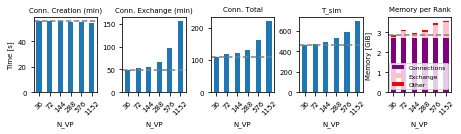

In [102]:
hpc_pop_comp = pd.read_csv('benchmark_results/hpc_pop_comp_benchmark_conn_sort_update_daint_t6_s44.csv')

hpc_pop_comp = calculate_T_conn_and_memory(hpc_pop_comp)

hpc_pop_comp_p = plot_results(hpc_pop_comp, 'benchmark_figures/hpc_benchmark_many_neurons.pdf')

save_table_latex(hpc_pop_comp_p.to_latex(), 'latex_tables/hpc_benchmark_many_neurons_table.txt')

print(hpc_pop_comp['N_conns_sum'])
print(hpc_pop_comp['N_nrns'])
hpc_pop_comp_p

## Population model

0     2500000000
1     5000000000
2    10000000000
3    20000000000
4    40000000000
5    80000000000
Name: N_conns_sum, dtype: int64
0      500000
1     1000000
2     2000000
3     4000000
4     8000000
5    16000000
Name: N_nrns, dtype: int64


,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
NUM_VPS,,,,,,
36,44.25,39.58,86.77,1.982666,0.095207,0.062289
72,44.43,40.50,88.60,1.978109,0.139478,0.068432
144,46.16,41.46,91.95,1.978109,0.220167,0.068452
288,48.49,43.75,95.33,1.978109,0.124685,0.068463
576,53.36,54.05,110.80,1.978109,0.398448,0.068817
1152,64.57,96.74,172.28,1.978109,0.443953,0.069519


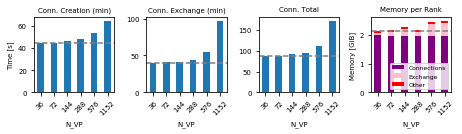

In [27]:
population = pd.read_csv('benchmark_results/population_model_conn_sort_update_daint_t6.csv')

population = calculate_T_conn_and_memory(population)
population_p = plot_results(population, 'benchmark_figures/population_model.pdf', plot_T_sim=False)

save_table_latex(population_p.to_latex(), 'latex_tables/population_model_table.txt')

print(population['N_conns_sum'])
print(population['N_nrns'])
population_p

## Compare

### HPC benchmark vs HPC benchmark with many synapses per neuron

Conn. Creation (min)               Conn. Exchange (min)                \
Case                 Default many synapses              Default many synapses   
NUM_VPS                                                                         
36                     54.30         55.78                42.19         49.72   
72                     53.72         55.91                42.97         53.33   
144                    54.19         55.52                44.75         54.99   
288                    53.67         55.37                48.82         65.72   
576                    52.43         54.80                60.34         96.50   
1152                   52.39         54.48                79.09        156.48   

        Conn. Total               Memory per Rank                
Case        Default many synapses         Default many synapses  
NUM_VPS                                                          
36            99.81        110.99        2.818396      2.836591  
72           102.35        118.45        2.820551      3.110994  
144          105.35        121.10        2.906020      2.962012  
288          109.34        130.18        2.910942      3.105962  
576          120.57        161.45        3.037008      3.447438  
1152         139.73        221.62        3.374027      3.565286

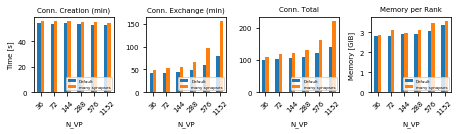

In [118]:
hpc_t6_s20['Case'] = ['Default'] * len(hpc_t6_s20)
hpc_pop_comp['Case'] = ['many synapses'] * len(hpc_pop_comp)

hpc_cases = pd.concat([hpc_t6_s20, hpc_pop_comp])

hpc_synapse_cases_p = plot_compare(hpc_cases, 'benchmark_figures/hpc_synapse_cases.pdf')
save_table_latex(hpc_synapse_cases_p.to_latex(), 'latex_tables/hpc_synapse_cases_table.txt')

hpc_synapse_cases_p

#### time per connection

Conn. Creation Time per Conn. (min)                \
Case                                Default many synapses   
NUM_VPS                                                     
36                             2.144994e-08  2.232986e-08   
72                             1.061041e-08  1.119095e-08   
144                            5.351623e-09  5.556446e-09   
288                            2.650135e-09  2.770717e-09   
576                            1.294453e-09  1.371097e-09   
1152                           6.467326e-10  6.815454e-10   

        Conn. Exchange Time per Conn. (min)                \
Case                                Default many synapses   
NUM_VPS                                                     
36                             1.666617e-08  1.990392e-08   
72                             8.487145e-09  1.067454e-08   
144                            4.419360e-09  5.503403e-09   
288                            2.410650e-09  3.288631e-09   
576                            1.489744e-09  2.414432e-09   
1152                           9.763330e-10  1.957566e-09   

        Total Conn. Time per Conn.                
Case                       Default many synapses  
NUM_VPS                                           
36                    3.942759e-08  4.443154e-08  
72                    2.021548e-08  2.370897e-08  
144                   1.040401e-08  1.211970e-08  
288                   5.399026e-09  6.514212e-09  
576                   2.976772e-09  4.039482e-09  
1152                  1.724908e-09  2.772468e-09

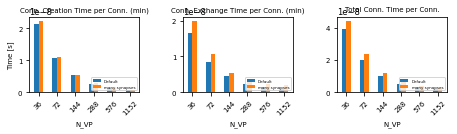

In [119]:
hpc_cases = time_per_connection(hpc_cases)
values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

hpc_synapse_cases_tpc__p = plot_compare(hpc_cases, 'benchmark_figures/hpc_synapse_cases_time_per_conn.pdf', values)
save_table_latex(hpc_synapse_cases_tpc__p.to_latex(), 'latex_tables/hpc_synapse_cases_time_per_conn_table.txt')

hpc_synapse_cases_tpc__p

### HPC benchmark with many synapses per neuron vs block Population model

Conn. Creation (min)            Conn. Exchange (min)             \
Case           many synapses population        many synapses population   
NUM_VPS                                                                   
36                     55.78      44.25                49.72      39.58   
72                     55.91      44.43                53.33      40.50   
144                    55.52      46.16                54.99      41.46   
288                    55.37      48.49                65.72      43.75   
576                    54.80      53.36                96.50      54.05   
1152                   54.48      64.57               156.48      96.74   

          Conn. Total            Memory per Rank             
Case    many synapses population   many synapses population  
NUM_VPS                                                      
36             110.99      86.77        2.836591   2.140162  
72             118.45      88.60        3.110994   2.186019  
144            121.10      91.95        2.962012   2.266728  
288            130.18      95.33        3.105962   2.171257  
576            161.45     110.80        3.447438   2.445374  
1152           221.62     172.28        3.565286   2.491581

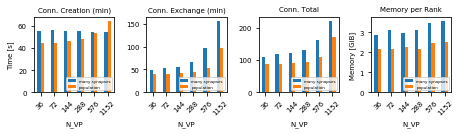

In [120]:
population['Case'] = ['population'] * len(population)

hpc_synapse_pop_cases = pd.concat([hpc_pop_comp, population])

hpc_synapse_pop_cases_p = plot_compare(hpc_synapse_pop_cases, 'benchmark_figures/hpc_synapse_vs_pop_cases.pdf')
save_table_latex(hpc_synapse_pop_cases_p.to_latex(), 'latex_tables/hpc_synapse_vs_pop_cases_table.txt')

hpc_synapse_pop_cases_p

#### time per connection

Conn. Creation Time per Conn. (min)                \
Case                          many synapses    population   
NUM_VPS                                                     
36                             2.232986e-08  1.770000e-08   
72                             1.119095e-08  8.886000e-09   
144                            5.556446e-09  4.616000e-09   
288                            2.770717e-09  2.424500e-09   
576                            1.371097e-09  1.334000e-09   
1152                           6.815454e-10  8.071250e-10   

        Conn. Exchange Time per Conn. (min)                \
Case                          many synapses    population   
NUM_VPS                                                     
36                             1.990392e-08  1.583200e-08   
72                             1.067454e-08  8.100000e-09   
144                            5.503403e-09  4.146000e-09   
288                            3.288631e-09  2.187500e-09   
576                            2.414432e-09  1.351250e-09   
1152                           1.957566e-09  1.209250e-09   

        Total Conn. Time per Conn.                
Case                 many synapses    population  
NUM_VPS                                           
36                    4.443154e-08  3.470800e-08  
72                    2.370897e-08  1.772000e-08  
144                   1.211970e-08  9.195000e-09  
288                   6.514212e-09  4.766500e-09  
576                   4.039482e-09  2.770000e-09  
1152                  2.772468e-09  2.153500e-09

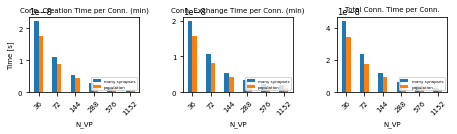

In [121]:
hpc_synapse_pop_cases = time_per_connection(hpc_synapse_pop_cases)
values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

hpc_synapse_pop_tpc_cases_p = plot_compare(hpc_synapse_pop_cases,
                                           'benchmark_figures/hpc_synapse_vs_pop_cases_time_per_conn.pdf', values)
save_table_latex(hpc_synapse_pop_tpc_cases_p.to_latex(),
                 'latex_tables/hpc_synapse_vs_pop_cases_time_per_conn_table.txt')

hpc_synapse_pop_tpc_cases_p

### Compare nblocks and population

Conn. Creation Time per Conn. (min)                                   \
Case                                NBLOCKS increasing NBLOCKS    population   
NUM_VPS                                                                        
36                             3.718382e-08       3.718382e-08  1.770000e-08   
72                             1.885377e-08       4.593822e-08  8.886000e-09   
144                            9.694696e-09       7.750313e-08  4.616000e-09   
288                            5.081434e-09       1.466059e-07  2.424500e-09   
576                            2.790176e-09                NaN  1.334000e-09   
1152                           1.652979e-09                NaN  8.071250e-10   

        Conn. Exchange Time per Conn. (min)                                   \
Case                                NBLOCKS increasing NBLOCKS    population   
NUM_VPS                                                                        
36                             1.735800e-08       1.726278e-08  1.583200e-08   
72                             8.744468e-09       8.637345e-09  8.100000e-09   
144                            4.526969e-09       4.388076e-09  4.146000e-09   
288                            2.421195e-09       2.364396e-09  2.187500e-09   
576                            1.431292e-09                NaN  1.351250e-09   
1152                           9.623777e-10                NaN  1.209250e-09   

        Total Conn. Time per Conn.                                   
Case                       NBLOCKS increasing NBLOCKS    population  
NUM_VPS                                                              
36                    5.581938e-08       5.612091e-08  3.470800e-08  
72                    2.815965e-08       5.750559e-08  1.772000e-08  
144                   1.479398e-08       8.718343e-08  9.195000e-09  
288                   7.938066e-09       1.668952e-07  4.766500e-09  
576                   4.422573e-09                NaN  2.770000e-09  
1152                  2.720248e-09                NaN  2.153500e-09

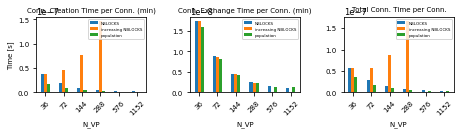

In [32]:
hpc_split_t6_s20['Case']          = ['NBLOCKS']*len(hpc_split_t6_s20)
hpc_split_increase_t6_s20['Case'] = ['increasing NBLOCKS']*len(hpc_split_increase_t6_s20)
population['Case']                = ['population']*len(population)

increasing_conns = pd.concat([hpc_split_t6_s20, hpc_split_increase_t6_s20, population])

increasing_conns = time_per_connection(increasing_conns)

values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

increasing_conns_p = plot_compare(increasing_conns, 'benchmark_figures/nblocks_vs_population.pdf',
                                  values=values, legend_loc='upper right')
save_table_latex(increasing_conns_p.to_latex(), 'latex_tables/nblocks_vs_population.txt')

increasing_conns_p

## Multi-Area Model

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,T_sim,connections,ini,other
NUM_VPS,,,,,,,
36,120.324007,34.458346,154.782448,1082.365881,2.551994,0.063860,-5.551115e-17
72,161.378545,42.557043,203.935915,1390.129490,2.550975,0.067006,2.189128e-02
144,245.404073,44.667060,290.071874,1664.842568,2.553382,0.171119,7.039388e-03
288,411.967277,46.147448,458.115551,2055.187021,2.626202,0.254059,-2.220446e-16
576,743.367733,36.390803,779.763724,60.539340,2.677456,0.106130,-5.551115e-17
1152,1461.262587,65.228588,1526.492920,3346.249244,2.939487,0.453178,1.665335e-16


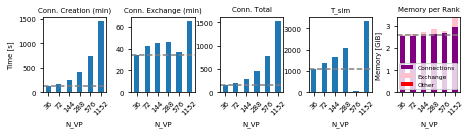

In [36]:
MAM_t6_s0_0625 = pd.read_csv('benchmark_results/MAM_conn_sort_update_daint_t6_s0_0625.csv')

MAM_t6_s0_0625['T_conns_min'] = MAM_t6_s0_0625['T_network_global_min'] + MAM_t6_s0_0625['T_connect_min']
MAM_t6_s0_0625['T_conns_max'] = MAM_t6_s0_0625['T_network_global_max'] + MAM_t6_s0_0625['T_connect_max']

MAM_t6_s0_0625 = calculate_T_conn_and_memory(MAM_t6_s0_0625)
MAM_t6_s0_0625_p = plot_results(MAM_t6_s0_0625, 'benchmark_figures/multi-area-model.pdf', plot_T_sim=True)

save_table_latex(MAM_t6_s0_0625_p.to_latex(), 'latex_tables/multi-area-model_table.txt')
MAM_t6_s0_0625_p

## 4x4 mesocircuit

,NUMBER_OF_NODES,TASKS_PER_NODE,THREADS_PER_TASK,SCALE,NUM_VPS,hash,num_tasks,T_nrns,T_conns_avg,T_conns_min,...,N_conns_sum,T_bld_xn,T_bld_nx,Conn. Total,Conn. Creation (min),Conn. Exchange (min),connections,ini,other,Memory per Rank
0,1,6,6,0.0625,36,acd429db3b9ab17b5f5391184e500dc6,6,0.55,169.435000,169.10,...,345443323,175.15,175.65,175.15,169.10,6.05,0.502441,0.112576,0.049678,0.664696
1,2,6,6,0.1250,72,acd429db3b9ab17b5f5391184e500dc6,12,0.94,193.399167,193.27,...,690927633,199.94,200.46,199.94,193.27,6.66,0.521647,0.103027,0.063959,0.688634
2,4,6,6,0.2500,144,acd429db3b9ab17b5f5391184e500dc6,24,2.18,227.260833,226.92,...,1381963143,234.20,234.88,234.20,226.92,7.27,0.540202,0.123834,0.075698,0.739733
3,8,6,6,0.5000,288,acd429db3b9ab17b5f5391184e500dc6,48,3.88,330.619792,330.18,...,2763938640,338.22,339.09,338.22,330.18,8.02,0.455751,0.173929,0.103053,0.732733
4,16,6,6,1.0000,576,acd429db3b9ab17b5f5391184e500dc6,96,7.97,519.575833,519.27,...,5527888387,529.73,530.76,529.73,519.27,10.44,0.409619,0.233214,0.171115,0.813949
5,32,6,6,2.0000,1152,acd429db3b9ab17b5f5391184e500dc6,192,21.36,927.114583,926.42,...,11055874121,940.37,942.03,940.37,926.42,13.87,0.410835,0.363299,0.303653,1.077786


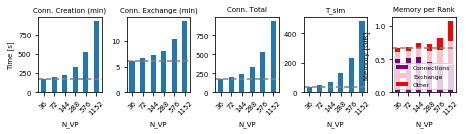

In [37]:
meso_t6_s0_0625 = pd.read_csv('benchmark_results/4x4_mesocircuit_conn_sort_update_daint_t6_s0_0625.csv')

meso_t6_s0_0625 = calculate_T_conn_and_memory(meso_t6_s0_0625)
meso_t6_s0_0625_p = plot_results(meso_t6_s0_0625, 'benchmark_figures/mesocircuit.pdf', plot_T_sim=True)

save_table_latex(meso_t6_s0_0625_p.to_latex(), 'latex_tables/mesocircuit_table.txt')
meso_t6_s0_0625

### Comapare hpc, population, MAM and 4x4

Conn. Creation Time per Conn. (min)                              \
Case                                    4x4           MAM           hpc   
NUM_VPS                                                                   
36                             4.895159e-07  7.976827e-08  2.144994e-08   
72                             2.797254e-07  5.349252e-08  1.061041e-08   
144                            1.642012e-07  4.067230e-08  5.351623e-09   
288                            1.194600e-07  3.413890e-08  2.650135e-09   
576                            9.393641e-08  3.080069e-08  1.294453e-09   
1152                           8.379437e-08  3.027296e-08  6.467326e-10   

                      Conn. Exchange Time per Conn. (min)                \
Case       population                                 4x4           MAM   
NUM_VPS                                                                   
36       1.770000e-08                        1.751373e-08  2.284401e-08   
72       8.886000e-09                        9.639215e-09  1.410648e-08   
144      4.616000e-09                        5.260632e-09  7.402941e-09   
288      2.424500e-09                        2.901656e-09  3.824146e-09   
576      1.334000e-09                        1.888605e-09  1.507816e-09   
1152     8.071250e-10                        1.254537e-09  1.351340e-09   

                                    Total Conn. Time per Conn.                \
Case              hpc    population                        4x4           MAM   
NUM_VPS                                                                        
36       1.666617e-08  1.583200e-08               5.070296e-07  1.026123e-07   
72       8.487145e-09  8.100000e-09               2.893791e-07  6.759911e-08   
144      4.419360e-09  4.146000e-09               1.694691e-07  4.807536e-08   
288      2.410650e-09  2.187500e-09               1.223689e-07  3.796311e-08   
576      1.489744e-09  1.351250e-09               9.582864e-08  3.230872e-08   
1152     9.763330e-10  1.209250e-09               8.505614e-08  3.162434e-08   

                                     
Case              hpc    population  
NUM_VPS                              
36       3.942759e-08  3.470800e-08  
72       2.021548e-08  1.772000e-08  
144      1.040401e-08  9.195000e-09  
288      5.399026e-09  4.766500e-09  
576      2.976772e-09  2.770000e-09  
1152     1.724908e-09  2.153500e-09

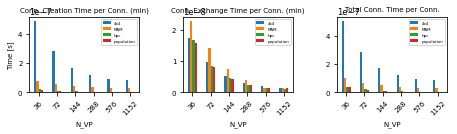

In [45]:
hpc_t6_s20['Case']      = ['hpc']*len(hpc_t6_s20)
MAM_t6_s0_0625['Case']  = ['MAM']*len(MAM_t6_s0_0625)
meso_t6_s0_0625['Case'] = ['4x4']*len(meso_t6_s0_0625)
population['Case']      = ['population']*len(population)

hpc_pop_MAM_4x4 = pd.concat([hpc_t6_s20, population, MAM_t6_s0_0625, meso_t6_s0_0625])

hpc_pop_MAM_4x4 = time_per_connection(hpc_pop_MAM_4x4)

values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

hpc_pop_MAM_4x4_p = plot_compare(hpc_pop_MAM_4x4, 'benchmark_figures/hpc_population_MAM_4x4.pdf',
                                 values=values, legend_loc='upper right')
save_table_latex(hpc_pop_MAM_4x4_p.to_latex(), 'latex_tables/hpc_population_MAM_4x4_table.txt')

hpc_pop_MAM_4x4_p

## Different `Connect` rules
Compare different connection rules, `SCALE = 2 * NUMBER_OF_NODES`

**Compare *all* rules:**

Conn. Creation Time per Conn. (min)                              \
Case                             all_to_all     bernoulli      indegree   
NUM_VPS                                                                   
36                             2.171445e-08  2.922655e-08  2.231063e-08   
72                             1.086125e-08  1.446784e-08  1.091110e-08   
144                            5.307987e-09  7.234027e-09  5.604309e-09   
288                            2.530716e-09  4.118205e-09  2.666428e-09   
576                            1.280828e-09  2.770082e-09  1.352966e-09   
1152                           6.404231e-10  2.103520e-09  6.690762e-10   

                                          Conn. Exchange Time per Conn. (min)  \
Case        outdegree symmetric bernoulli                          all_to_all   
NUM_VPS                                                                         
36       1.205108e-07        3.333932e-07                        1.579233e-08   
72       9.504585e-08        3.337404e-07                        9.380168e-09   
144      8.380753e-08        3.442622e-07                        4.937662e-09   
288      7.913786e-08        4.238485e-07                        2.870202e-09   
576      7.686678e-08        6.299211e-07                        1.342554e-09   
1152     7.547527e-08                 NaN                        7.252984e-10   

                                                                       \
Case        bernoulli      indegree     outdegree symmetric bernoulli   
NUM_VPS                                                                 
36       2.251234e-08  2.250807e-08  1.989154e-08        5.589472e-08   
72       1.170265e-08  1.204665e-08  1.216209e-08        3.979213e-08   
144      4.851489e-09  5.061160e-09  1.355189e-08        2.059056e-08   
288      2.617085e-09  2.700993e-09  7.875299e-09        1.191498e-08   
576      1.385041e-09  1.449254e-09  4.667450e-09        6.597118e-09   
1152     8.530120e-10  8.493071e-10  2.565192e-09                 NaN   

        Total Conn. Time per Conn.                                            \
Case                    all_to_all     bernoulli      indegree     outdegree   
NUM_VPS                                                                        
36                    4.342891e-08  5.568843e-08  5.192651e-08  1.735065e-07   
72                    2.468465e-08  2.834314e-08  2.517947e-08  1.741902e-07   
144                   1.185039e-08  1.334468e-08  1.175177e-08  1.319063e-07   
288                   6.234202e-09  7.278458e-09  5.994526e-09  1.039075e-07   
576                   3.016889e-09  4.429169e-09  3.128116e-09  9.536957e-08   
1152                  1.547046e-09  3.192314e-09  1.689973e-09  8.811152e-08   

                             
Case    symmetric bernoulli  
NUM_VPS                      
36             4.232593e-07  
72             3.963414e-07  
144            3.901836e-07  
288            4.409531e-07  
576            6.534900e-07  
1152                    NaN

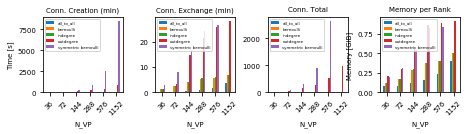

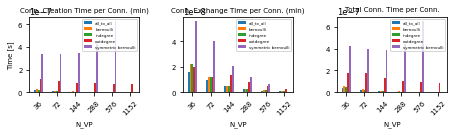

In [23]:
hpc_in = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s2_in.csv')
hpc_in['Case'] = ['indegree']*len(hpc_in)

hpc_out = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s2_out.csv')
hpc_out['Case'] = ['outdegree']*len(hpc_out)

hpc_bern = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s2_bern.csv')
hpc_bern['Case'] = ['bernoulli']*len(hpc_bern)

hpc_all = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s2_all.csv')
hpc_all['Case'] = ['all_to_all']*len(hpc_all)

hpc_sym = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s2_sym.csv')
hpc_sym['Case'] = ['symmetric bernoulli']*len(hpc_sym)

#hpc_one = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_t6_s2_one.csv')
#hpc_one['case'] = ['one_to_one']*len(hpc_one)

hpc_rules = pd.concat([hpc_in, hpc_out, hpc_bern, hpc_all, hpc_sym])#, hpc_one])

hpc_rules = calculate_T_conn_and_memory(hpc_rules)
hpc_rules = time_per_connection(hpc_rules)

values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

hpc_rules_p = plot_compare(hpc_rules, 'benchmark_figures/hpc_rules_all.pdf', legend_placement='upper left')
save_table_latex(hpc_rules_p.to_latex(), 'latex_tables/hpc_rules_all_table.txt')
hpc_rules_p = plot_compare(hpc_rules, 'benchmark_figures/hpc_rules_all_time_per_connection.pdf',
                           values, legend_loc='upper right')
save_table_latex(hpc_rules_p.to_latex(), 'latex_tables/hpc_rules_all_time_per_connection_table.txt')

hpc_rules_p

**Compare *fixed_indegree, pairwise_bernoulli, all_to_all*:**

Conn. Creation Time per Conn. (min)                              \
Case                             all_to_all     bernoulli      indegree   
NUM_VPS                                                                   
36                             2.171445e-08  2.922655e-08  2.231063e-08   
72                             1.086125e-08  1.446784e-08  1.091110e-08   
144                            5.307987e-09  7.234027e-09  5.604309e-09   
288                            2.530716e-09  4.118205e-09  2.666428e-09   
576                            1.280828e-09  2.770082e-09  1.352966e-09   
1152                           6.404231e-10  2.103520e-09  6.690762e-10   

        Conn. Exchange Time per Conn. (min)                              \
Case                             all_to_all     bernoulli      indegree   
NUM_VPS                                                                   
36                             1.579233e-08  2.251234e-08  2.250807e-08   
72                             9.380168e-09  1.170265e-08  1.204665e-08   
144                            4.937662e-09  4.851489e-09  5.061160e-09   
288                            2.870202e-09  2.617085e-09  2.700993e-09   
576                            1.342554e-09  1.385041e-09  1.449254e-09   
1152                           7.252984e-10  8.530120e-10  8.493071e-10   

        Total Conn. Time per Conn.                              
Case                    all_to_all     bernoulli      indegree  
NUM_VPS                                                         
36                    4.342891e-08  5.568843e-08  5.192651e-08  
72                    2.468465e-08  2.834314e-08  2.517947e-08  
144                   1.185039e-08  1.334468e-08  1.175177e-08  
288                   6.234202e-09  7.278458e-09  5.994526e-09  
576                   3.016889e-09  4.429169e-09  3.128116e-09  
1152                  1.547046e-09  3.192314e-09  1.689973e-09

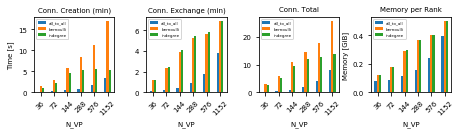

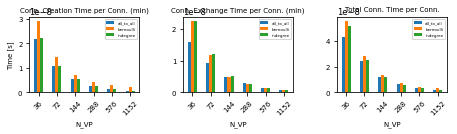

In [22]:
hpc_rules_few = pd.concat([hpc_in, hpc_bern, hpc_all])

hpc_rules_few = calculate_T_conn_and_memory(hpc_rules_few)
hpc_rules_few = time_per_connection(hpc_rules_few)

values = ['Conn. Creation Time per Conn. (min)',
          'Conn. Exchange Time per Conn. (min)',
          'Total Conn. Time per Conn.']

hpc_rules_few_p = plot_compare(hpc_rules_few, 'benchmark_figures/hpc_rules_fewer.pdf',
                               legend_placement='upper left')
save_table_latex(hpc_rules_few_p.to_latex(), 'latex_tables/hpc_rules_fewer_table.txt')
hpc_rules_few_p = plot_compare(hpc_rules_few, 'benchmark_figures/hpc_rules_fewer_time_per_connection.pdf',
                               values, legend_loc='upper right')
save_table_latex(hpc_rules_few_p.to_latex(), 'latex_tables/hpc_rules_fewer_time_per_connection_table.txt')

hpc_rules_few_p

## Fixed VP, different threads.

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,T_sim,connections,ini,other
Threads,,,,,,,
1,22.13,15.56,38.36,141.26,2.724609,0.234478,0.395222
3,39.30,33.40,81.39,182.57,2.743164,0.055838,0.099345
6,53.85,42.48,100.92,193.57,2.743245,0.019534,0.055941
9,56.42,66.25,124.45,188.59,2.742622,0.007792,0.045253
18,72.88,98.26,174.78,196.08,2.746012,0.031669,0.031951
32,104.03,108.28,212.31,438.17,2.759644,0.013889,0.026946


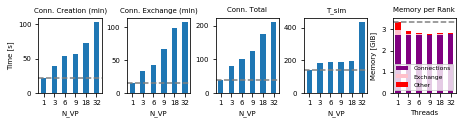

In [56]:
hpc_threads_n1 = pd.read_csv('benchmark_results/hpc_benchmark_conn_sort_update_daint_s20_threads.csv')

hpc_threads_n1 = calculate_T_conn_and_memory(hpc_threads_n1)

hpc_threads_n1['Threads'] = hpc_threads_n1['THREADS_PER_TASK']

hpc_threads_n1_p = plot_results(hpc_threads_n1, 'benchmark_figures/hpc_fixedVP_diff_threads_n1.pdf',
                                index='Threads', rot=0)

save_table_latex(hpc_threads_n1_p.to_latex(), 'latex_tables/hpc_fixedVP_diff_threads_n1_table.txt')
hpc_threads_n1_p

Conn. Creation (min)                       Conn. Exchange (min)  \
Case                    2.14   2.16     5g  master                 2.14   
Threads                                                                   
1                      48.96  27.44  20.58   26.59                 0.74   
3                      65.72  49.01  35.65   44.50                 1.14   
6                      71.94    NaN  46.75   58.02                 1.32   
9                      73.45    NaN  50.20   60.08                 1.18   
18                     75.75    NaN  63.14   76.86                 1.27   
36                     89.67    NaN  84.79  100.01                 1.88   

                               Conn. Total                         \
Case      2.16      5g  master        2.14   2.16      5g  master   
Threads                                                             
1          NaN   25.37   14.96       51.68    NaN   47.37   42.41   
3        40.79   32.34   33.05       72.07  96.08   73.83   85.81   
6          NaN   43.40   42.33       78.79    NaN   91.08  106.22   
9          NaN   46.54   64.84       77.40    NaN   97.98  130.10   
18         NaN   64.40   92.64       79.30    NaN  129.18  173.03   
36         NaN  134.14  104.20       91.55    NaN  218.93  204.21   

        Memory per Rank                                
Case               2.14      2.16        5g    master  
Threads                                                
1              3.131454       NaN  4.381996  3.354645  
3              2.838875  4.414881  3.916854  2.901877  
6              2.796472       NaN  3.829361  2.817963  
9              2.787800       NaN  3.809237  2.797168  
18             2.778902       NaN  3.789648  2.810139  
36             2.786571       NaN  3.783141  2.800488

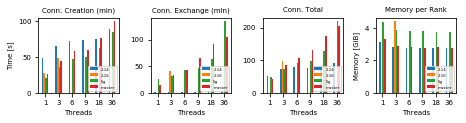

In [59]:
hpc_threads_214 = pd.read_csv('../benchmark_results/hpc_benchmark_214_daint_threads.csv')
hpc_threads_214['Case'] = ['2.14']*len(hpc_threads_214)
hpc_threads_216 = pd.read_csv('../benchmark_results/hpc_benchmark_216_daint_threads.csv')
hpc_threads_216['Case'] = ['2.16']*len(hpc_threads_216)
hpc_threads_m   = pd.read_csv('../benchmark_results/hpc_benchmark_master_daint_threads.csv')
hpc_threads_m['Case']   = ['master']*len(hpc_threads_m)
hpc_threads_5g  = pd.read_csv('../benchmark_results/hpc_benchmark_5g_daint_threads.csv')
hpc_threads_5g['Case']  = ['5g']*len(hpc_threads_5g)
# hpc_threads_3   = pd.read_csv('benchmark_results/hpc_benchmark_3_daint_threads.csv')
# hpc_threads_3['version']   = ['3']*len(hpc_threaDs_3)

hpc_threads = pd.concat([hpc_threads_214, hpc_threads_216, hpc_threads_m, hpc_threads_5g])

hpc_threads = calculate_T_conn_and_memory(hpc_threads)
hpc_threads['Threads'] = hpc_threads['THREADS_PER_TASK']
hpc_threads_p = plot_compare(hpc_threads, 'benchmark_figures/tester.pdf', index='Threads', rot=0)

hpc_threads_p